In [1]:
import pandas as pd 
from datetime import datetime
from pytz import timezone
import numpy as np
import csv 
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

UsageError: Line magic function `%` not found.


In [ ]:
# does not read the csv file correctly for sleep; what do the columns mean when they're just numbers?
sleep_data = pd.read_csv('scripps1_sleep.csv')
motion_data = pd.read_csv('scripps1_motion.csv',sep=';')
ibi_data = pd.read_csv('scripps1_ibi.csv',sep=';')

In [ ]:
def sleep_dataset_reader(str_dataset):
    ''' This function takes a string of location of sleep csv and properly formats it to be read as a dataframe.
    Parameters: String, which is the location of the sleep dataset
    Returns: Returns a dataframe with proper format; dataframe does not extend past header columns
    '''
    test = open(str_dataset,'r')
    lines = test.readlines()
    columns = len(lines[0].strip().split(';')) # splits into data points 
    cleaned_data = [] 
    list_rows = [] 
    for i in lines: 
        list_rows.append(i.strip().split(';'))
    for i in list_rows:
        cleaned_data.append(i[:columns])
    for row in cleaned_data:
        row.extend(0 for x in range(columns-len(row))) # extends rows; for some, 'sleep cycle max' is less than 899
    headers = cleaned_data.pop(0)
    df = pd.DataFrame(cleaned_data,columns = headers,dtype='float')
    df.replace(r'^\s*$', np.nan, regex=True, inplace = True) # replaces all the empty spaces with NaN 
    return df

In [3]:
df = sleep_dataset_reader('scripps1_sleep.csv')


NameError: name 'sleep_dataset_reader' is not defined

In [5]:
def dataset_cleaner(dataset):
    '''This function does a general clean of the sleep dataframe (changes variables to proper types, drops
    unimportant columns)
    Parameter: dataset, the sleep dataframe 
    Returns: Returns a cleaner dataframe that has proper dtypes and less unnecessary columns 
    
    WHAT'S NEEDED: TimeZone is unclear. For future reference, what the numbers are might be useful
    '''
    df = dataset.copy()
    df['Date'] =  pd.to_datetime(df['Date'], format='%d.%m.%Y') 
    # originally string, might be unnecessary? maybe convert to date; weekday vs weekend?
    df['Bedtime start Unix'] = pd.to_datetime(df['Bedtime start Unix'],unit='s') # originally string
    df['Bedtime end Unix'] = pd.to_datetime(df['Bedtime end Unix'],unit='s') # originally string 
    df = df.drop(['Bedtime start','Bedtime end'],axis=1) # unnecessary, since we already have bedtime unix's
    df = df[df['Debug info'] != 'Bedtime detection failed'] 
    # removes bedtime detection failed, rows lack info; line could be used to grab failing measurements in the future 
    str_list = list(filter(None, list(df.columns))) 
    # some columns have empty header and are empty, this gets rid of these columns 
    return df[str_list]

In [6]:
df_1 = dataset_cleaner(df)
df_1.head()

,Date,Bedtime start Unix,Bedtime end Unix,TimeZone,Debug info,Battery consumption,Is longest,Time in bed,Sleep Score,Sleep minutes,...,890,891,892,893,894,895,896,897,898,899
0,2018-11-27,2018-11-27 20:35:53,2018-11-27 20:49:53,-8.0,NaN,NaN,1.0,14.0,23.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-11-27,2018-11-28 01:17:55,2018-11-28 01:37:55,-8.0,NaN,NaN,1.0,20.0,23.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-11-28,2018-11-28 06:16:15,2018-11-28 15:32:15,-8.0,NaN,1.2%,1.0,556.0,94.0,514.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0
3,2018-11-28,2018-11-28 20:52:26,2018-11-28 21:12:26,-8.0,NaN,NaN,0.0,20.0,25.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-11-29,2018-11-29 03:44:43,2018-11-29 03:54:43,-8.0,NaN,NaN,1.0,10.0,23.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
def analysis_one(df):
    ''' Method used to split dataframe into initial interest columns first. Focuses on only the first few 
    columns, ignoring the sleep phases columns. Hopefully I can get some more information about those later on 
    Parameter: df, the cleaned sleep dataframe 
    Returns: returns dataframe with columns of interest, everything should be converted to numbers 
    
    THINGS TO CONSIDER: Maybe don't drop bed time/wake time. Could be something important (sleeping late at night
    vs sleeping earlier, etc.)
    '''
    area_interest = df.iloc[:,6:35].dropna(how='all', axis=1).drop('SleepMidPoint',axis=1)
    return area_interest.apply(pd.to_numeric)

In [8]:
df_2 = analysis_one(df_1)
df_2.head()

,Is longest,Time in bed,Sleep Score,Sleep minutes,Wake minutes,REM minutes,Light minutes,Deep minutes,Efficiency,Lowest HR time minutes,...,Temperature,Restless%,Got up count,Score Total,Score Deep,Score REM,Score Efficiency,Score Latancy,Score Disturbances,Score Alignment
0,1.0,14.0,23.0,4.0,10.0,0.0,4.0,0.0,29.0,6.0,...,0.0,102.0,0.0,1.0,1.0,1.0,1.0,76.0,99.0,1.0
1,1.0,20.0,23.0,0.0,20.0,0.0,0.0,0.0,0.0,8.0,...,0.0,NaN,0.0,1.0,1.0,1.0,1.0,76.0,99.0,1.0
2,1.0,556.0,94.0,514.0,43.0,212.0,230.0,73.0,92.0,102.0,...,36.7,38.0,0.0,97.0,82.0,100.0,98.0,96.0,81.0,100.0
3,0.0,20.0,25.0,10.0,11.0,0.0,10.0,0.0,48.0,8.0,...,36.7,86.0,0.0,1.0,1.0,1.0,19.0,82.0,99.0,1.0
4,1.0,10.0,23.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,36.7,NaN,0.0,1.0,1.0,1.0,1.0,76.0,99.0,6.0


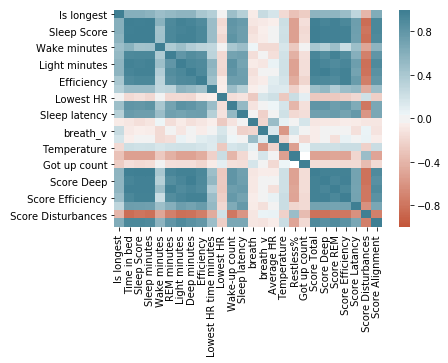

In [9]:
corr = df_2.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
);

In [14]:
df_2_no_low_corr = df_2.drop(['breath','breath_v','Average HR'],axis=1)

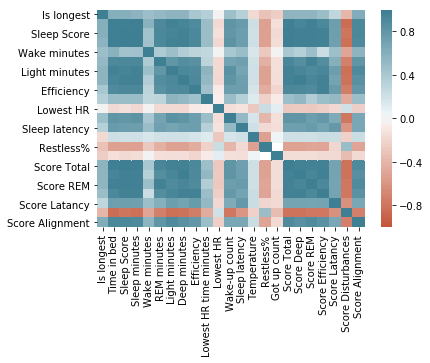

In [15]:
corr = df_2_no_low_corr.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
);

If we're purely focused on sleep score, variables of least interest are is_longest, wake_minutes (which makes sense, this should not affect our sleep score), lowest HR time minutes, lowest HR, temp, and get up count. Time in bed and sleep minutes have a big positive correlation, while score disturbances have the biggest negative correlations (assume score disturbances is the number of disturbances?). Obviously scores will have a big effect (score total, score deep, etc.) so those won't need a lot of scrutiny; time in bed, sleep minutes, lengths of sleep in different sleep phases, wake up count, and sleep latency are of biggest interest.

## Analysis on Time in Bed/Sleep Minutes

In [16]:
def naps_and_sleep(df):
    ''' Method used to split dataframe into two dataframes; one focused on naps (sleep minutes less than 30 
    minutes) and one focused on concrete sleep (sleep minutes equal to or more than 30 minutes)
    Parameter: df, the cleaned sleep dataframe 
    Returns: returns two dataframes, first one being naps (naps dataframe), second one being sleep (sleep dataframe)
    
    POTENTIAL SOURCE: https://www.sleep.org/articles/how-long-to-nap/
    '''
    naps = df[df['Sleep minutes']<30]
    sleep = df[df['Sleep minutes']>=30]
    return naps,sleep

In [17]:
naps,sleep = naps_and_sleep(df_1.iloc[:,0:33])
naps.shape,sleep.shape
# relatively equal splits

((20, 33), (15, 33))

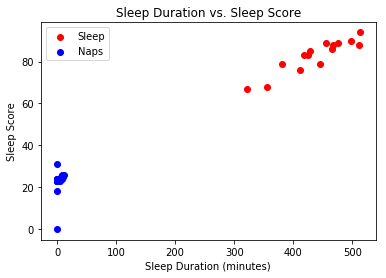

In [18]:
f, ax = plt.subplots()
ax.scatter('Sleep minutes', 'Sleep Score', data = sleep, color='r',label='Sleep')
ax.scatter('Sleep minutes', 'Sleep Score', data = naps, color='b',label='Naps')
ax.set_ylabel('Sleep Score')
ax.set_xlabel('Sleep Duration (minutes)')
ax.set_title('Sleep Duration vs. Sleep Score')
leg = ax.legend();
# not worth to plot both together

In [1]:
plt.scatter(naps['Sleep minutes'],naps['Sleep Score'],color='b')
plt.plot(np.unique(naps['Sleep minutes']), np.poly1d(np.polyfit(naps['Sleep minutes'], naps['Sleep Score']
                                                                , 1))(np.unique(naps['Sleep minutes'])),color='b')
plt.xlabels('asdf')
# why do the sleep scores vary so much when you sleep for 0 minutes

NameError: name 'plt' is not defined

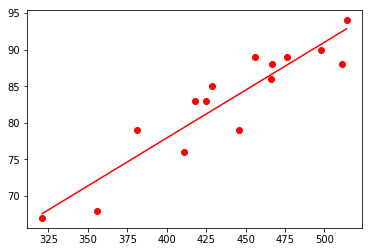

In [22]:
plt.scatter(sleep['Sleep minutes'],sleep['Sleep Score'],color='r')
plt.plot(np.unique(sleep['Sleep minutes']), np.poly1d(np.polyfit(sleep['Sleep minutes'], sleep['Sleep Score']
                                                                , 1))(np.unique(sleep['Sleep minutes'])),color='r')

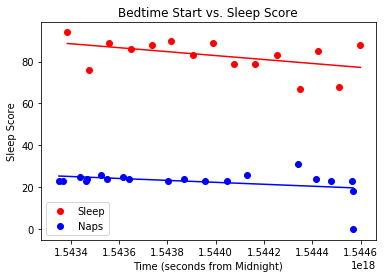

In [23]:
f, ax = plt.subplots()
ax.scatter(sleep['Bedtime start Unix'].astype(int), 'Sleep Score', data = sleep,color='r',label='Sleep')
ax.scatter(naps['Bedtime start Unix'].astype(int), 'Sleep Score', data = naps,color='b',label='Naps')
ax.plot(sleep['Bedtime start Unix'].astype(int), np.poly1d(np.polyfit(sleep['Bedtime start Unix'].astype(int), sleep['Sleep Score']
                                                                , 1))(np.unique(sleep['Bedtime start Unix'].astype(int))),color='r')
ax.plot(naps['Bedtime start Unix'].astype(int), np.poly1d(np.polyfit(naps['Bedtime start Unix'].astype(int), naps['Sleep Score']
                                                                , 1))(np.unique(naps['Bedtime start Unix'].astype(int))),color='b')
ax.set_ylabel('Sleep Score')
ax.set_xlabel('Time (seconds from Midnight)')
ax.set_title('Bedtime Start vs. Sleep Score')
leg = ax.legend();

In [24]:
df_1.head()

,Date,Bedtime start Unix,Bedtime end Unix,TimeZone,Debug info,Battery consumption,Is longest,Time in bed,Sleep Score,Sleep minutes,...,890,891,892,893,894,895,896,897,898,899
0,2018-11-27,2018-11-27 20:35:53,2018-11-27 20:49:53,-8.0,NaN,NaN,1.0,14.0,23.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-11-27,2018-11-28 01:17:55,2018-11-28 01:37:55,-8.0,NaN,NaN,1.0,20.0,23.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-11-28,2018-11-28 06:16:15,2018-11-28 15:32:15,-8.0,NaN,1.2%,1.0,556.0,94.0,514.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0
3,2018-11-28,2018-11-28 20:52:26,2018-11-28 21:12:26,-8.0,NaN,NaN,0.0,20.0,25.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-11-29,2018-11-29 03:44:43,2018-11-29 03:54:43,-8.0,NaN,NaN,1.0,10.0,23.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


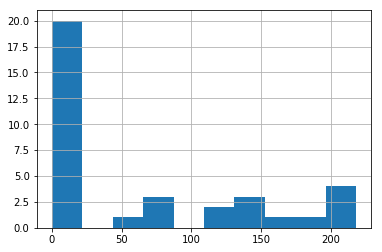

In [26]:
df_1['REM minutes'].hist()

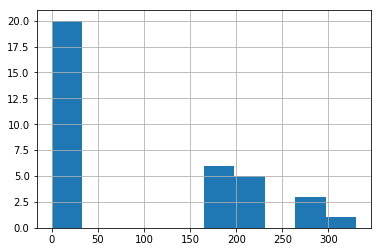

In [114]:
df_1['Light minutes'].hist()

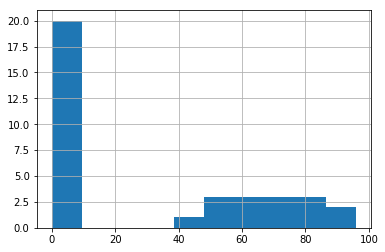

In [113]:
df_1['Deep minutes'].hist()

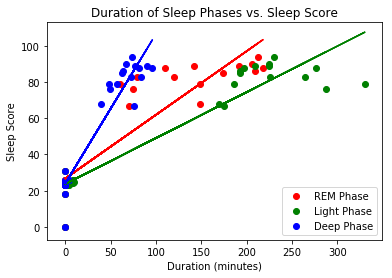

In [120]:
f, ax = plt.subplots()
ax.scatter('REM minutes', 'Sleep Score', data = df_1,color='r',label='REM Phase')
ax.plot(df_1['REM minutes'], np.poly1d(np.polyfit(df_1['REM minutes'], df_1['Sleep Score']
                                                                , 1))(df_1['REM minutes']),color='r')
ax.scatter('Light minutes', 'Sleep Score', data = df_1, color='g',label='Light Phase')
ax.plot(df_1['Light minutes'], np.poly1d(np.polyfit(df_1['Light minutes'], df_1['Sleep Score']
                                                                , 1))(df_1['Light minutes']),color='g')
ax.scatter('Deep minutes', 'Sleep Score', data = df_1, color='b',label='Deep Phase')
ax.plot(df_1['Deep minutes'], np.poly1d(np.polyfit(df_1['Deep minutes'], df_1['Sleep Score']
                                                                , 1))(df_1['Deep minutes']),color='b')
ax.set_ylabel('Sleep Score')
ax.set_xlabel('Duration (minutes)')
ax.set_title('Duration of Sleep Phases vs. Sleep Score')
leg = ax.legend();